## Tokenizing:

In [42]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\zh-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\zh-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [46]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\en-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\en-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [418]:
import unicodedata
import re

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

In [419]:
import io

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

In [420]:
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Tokening
def tokenize(lang):
    lang_tokenizer = T.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

In [421]:
# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [422]:
path_to_file_zh = r'H:\HLT\zh-Education.tok'
path_to_file_en = r'H:\HLT\en-Education.tok'

# Try experimenting with the size of that dataset
num_examples = 450#450000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file_zh, path_to_file_en, num_examples)

# Creating a reverse dictionary (index to word)
index_word_inp = dict(map(reversed, inp_lang.word_index.items()))
index_word_targ = dict(map(reversed, targ_lang.word_index.items()))

In [423]:
# Input tokens for encoder zero padded
num_encoder_tokens = len(inp_lang.word_index) + 1
# Input tokens for decoder zero padded
num_decoder_tokens = len(targ_lang.word_index) + 1
print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

Number of input tokens for encoder/decoder with zero padding: 3166, 2800


In [424]:
import numpy as np

# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Generate embedding vectors for <start> and <end> token
def initSpecialToken(vector_size, seed):
    np.random.seed(seed)
    return np.random.rand(vector_size)

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(num_tokens, trained_vector_path, vector_size):
    trained_word_vec = word2vec(trained_vector_path)
    print('number of trained word vector: {}:{}'.format(trained_vector_path, len(trained_word_vec)))

    embedding_matrix = np.zeros(num_tokens, vector_size)

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
import gzip
import os
import tarfile
import wget

# Download pre-trained Fasttext word embeddin
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz",out = r"G:\NLP\fasttext\cc.en.300.vec.gz")
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz",out = r"G:\NLP\fasttext\cc.zh.300.vec.gz")


# Uncompressing download files
def un_gz(file_name):
    """ungz zip file"""
    f_name = file_name.replace(".gz", "")
    g_file = gzip.GzipFile(file_name)
    open(f_name, "w+").write(g_file.read())
    g_file.close()
    
%cd "G:\NLP\fasttext\"
un_gz("cc.en.300.vec.gz")
un_gz("cc.zh.300.vec.gz")

In [ ]:
import numpy as np

vector_size = 300
trained_vector_paths = (r'G:\NLP\fasttext\cc.zh.300.vec', r'G:\NLP\fasttext\cc.en.300.vec')

# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(trained_vector_paths[0], vector_size, num_encoder_tokens)
# Save input embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\input_emb_matrix', input_emb_matrix)

In [ ]:
# Creating output embedding vectors and specify the <start>, <end> token
output_emb_matrix = get_embedding_matrix(trained_vector_paths[1], vector_size, num_decoder_tokens)
start_token_vec = initSpecialToken(vector_size, 0) #'<start>'
end_token_vec = initSpecialToken(vector_size, 1) # '<end>'
output_emb_matrix[targ_lang.word_index['<start>']] = start_token_vec
output_emb_matrix[targ_lang.word_index['<end>']] = end_token_vec
# Save output embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\output_emb_matrix', output_emb_matrix)

In [425]:
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'H:\HLT\Embedding_Matrix\input_emb_matrix.npy'), np.load(r'H:\HLT\Embedding_Matrix\output_emb_matrix.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

Embedding-matrix shape: (145824, 300), (210721, 300)


In [426]:
from sklearn.model_selection import train_test_split
import random

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Number of Training/validation samples
train_samples = len(input_tensor_train)
val_samples = len(input_tensor_val)
print('Number of samples for Training/Validation: {}, {}'.format(train_samples, val_samples))

Number of samples for Training/Validation: 360, 90


In [427]:
# Max length of input/target sentences
max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

Max length of input/target sentences: 49, 47


In [428]:
from keras.utils import to_categorical
import numpy as np

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size = 128):
    #zero padding all sequences
    encoder_input_tensor = S.pad_sequences(input_tensor,padding='post', maxlen = max_length_inp)
    # decoder input sequence does not include the <end> token
    decoder_input_tensor = S.pad_sequences([s[:-1] for s in target_tensor],padding='post', maxlen = max_length_targ)
    # decoder target sequence (one hot encoded) does not include the <START> token, Offset by one timestep
    decoder_target_tensor = np.array([to_categorical(t,len(targ_lang.word_index) + 1) for t in S.pad_sequences([s[1:] for s in target_tensor],padding='post', maxlen = max_length_targ)])

    # Generate a batch of data
    while True:
        for i in range(0, len(input_tensor), batch_size):
            encoder_input_batch = encoder_input_tensor[i:i + batch_size]
            decoder_input_batch = decoder_input_tensor[i:i + batch_size]
            decoder_target_batch = decoder_target_tensor[i:i + batch_size]
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

In [429]:
from keras.models import Model
from keras.layers import Activation, dot, Input, Embedding, LSTM, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout

latent_dim = 300
# Set up the encoder
encoder_inputs = Input(shape=(max_length_inp,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)(encoder_inputs)
#enc_emb = Dropout(0.1)(enc_emb)
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

In [430]:
from keras.layers import concatenate
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
# Embedding with with pre-trained embedding word vectors
dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
dec_emb = dec_emb_layer(decoder_inputs)
#dec_emb = Dropout(0.1)(dec_emb)
# We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)

# Attention layer
# (batch_size, max_length_inp, latent_dim) dot (latent_dim, latent_dim) => (batch_size, max_length_inp, latent_dim)
enc_dense = Dense(latent_dim*2, use_bias = False)
encoder = enc_dense(encoder_outputs)
# (batch_size, 1, latent_dim) dot (latent_dim, latent_dim) => (batch_size, 1, latent_dim)
dec_dense = Dense(latent_dim*2, use_bias = False)
decoder = dec_dense(decoder_outputs)
# (batch_size, 1, latent_dim) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, max_length_inp)
score = dot([decoder, encoder], axes=[2, 2])
# (batch_size, 1, max_length_inp) dot (max_length_inp, max_length_inp) => (batch_size, 1, max_length_inp)
score_dense = Dense(max_length_inp, activation='tanh')
score = score_dense(score)
attention_weights = Activation('softmax')(score)

# Context vector
# (batch_size, 1, max_length_inp) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, latent_dim)
context = dot([attention_weights, encoder], axes = [2,1])
# (batch_size, 1, latent_dim)
decoder_combined_context = concatenate([context, decoder_outputs])
atten_dense = Dense(latent_dim*2, use_bias = False, activation='tanh')
attention_vector = atten_dense(decoder_combined_context)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
#dense_time = TimeDistributed(decoder_dense)
#decoder_outputs = dense_time(decoder_outputs)
decoder_outputs = decoder_dense(attention_vector)

In [431]:
# Define the model that takes encoder and decoder input to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 49, 300)      949800      input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 49, 600), (N 1081800     embedding_3[0][0]                
__________________________________________________________________________________________________
embedding_

In [432]:
!apt install graphviz
!pip install pydot pydot-ng

'apt' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


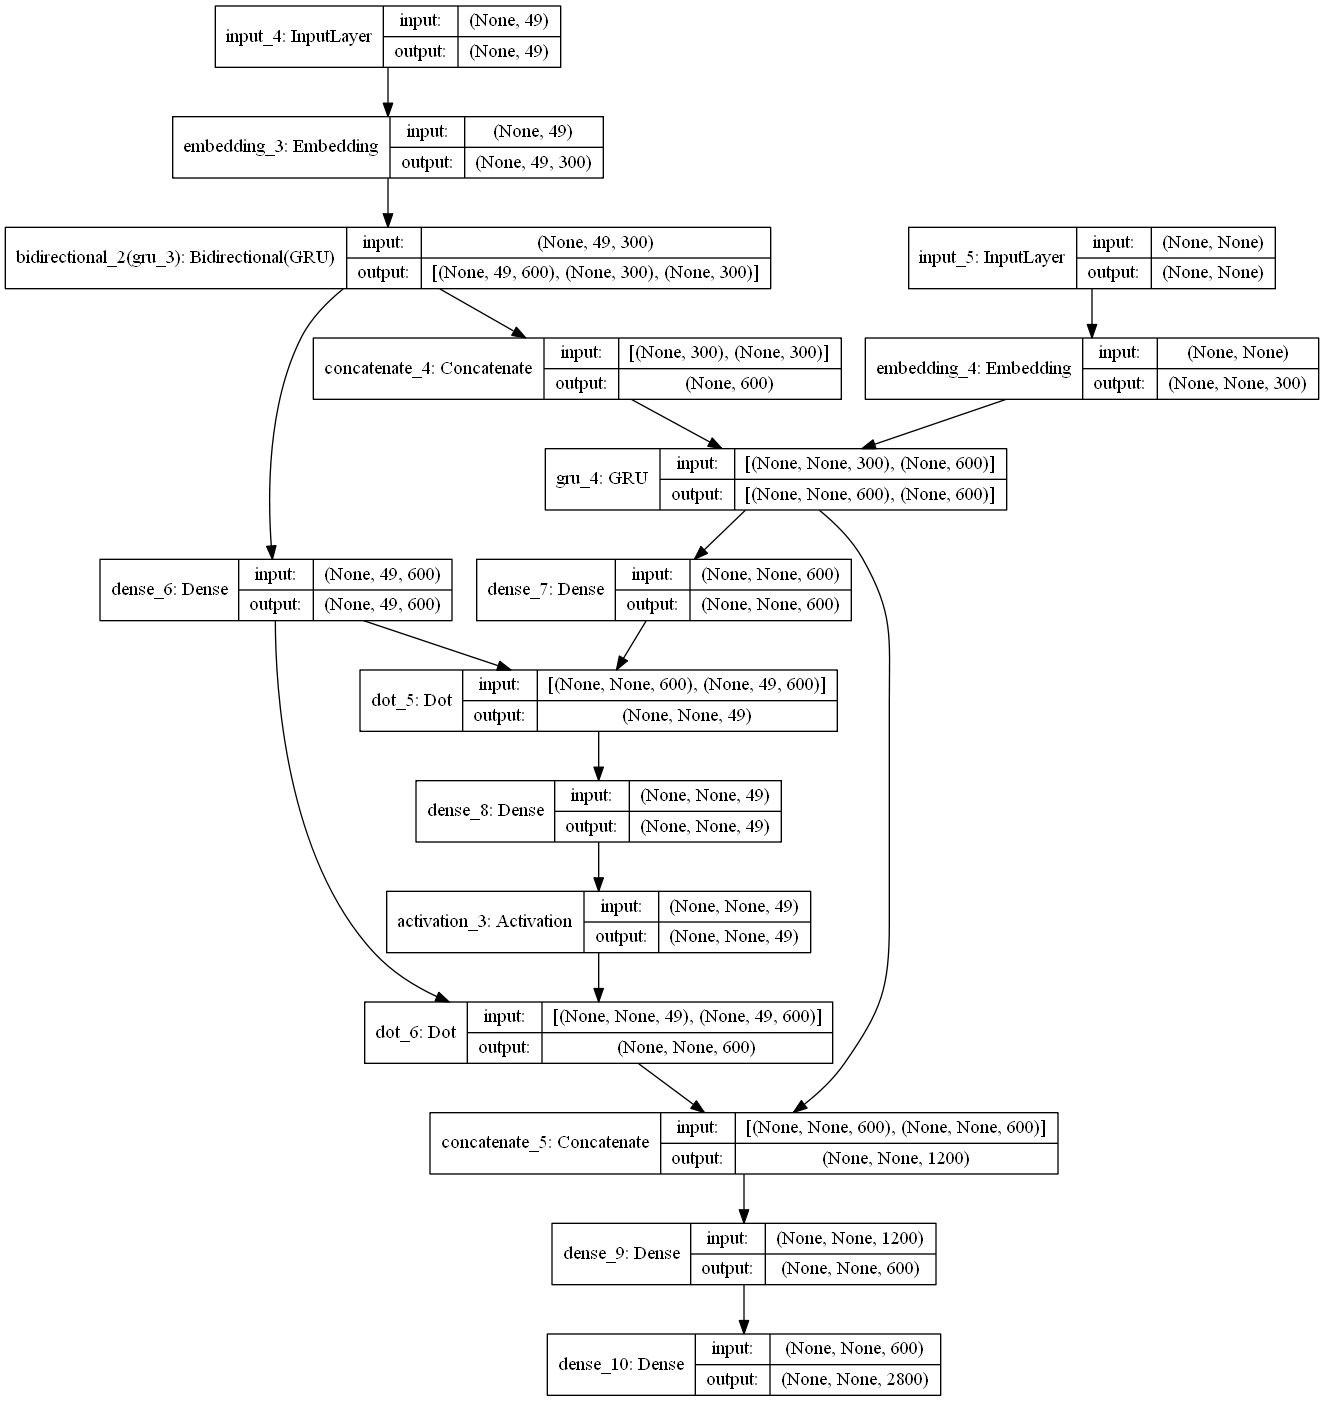

In [433]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [434]:
# Start training
batch_size = 20#128
epochs = 50#100
history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/50
18/18 [==============================] - 38s 2s/step - loss: 3.9511 - acc: 0.4832 - val_loss: 3.4223 - val_acc: 0.5138
Epoch 2/50
18/18 [==============================] - 30s 2s/step - loss: 3.2682 - acc: 0.5206 - val_loss: 3.3834 - val_acc: 0.5453
Epoch 3/50
18/18 [==============================] - 31s 2s/step - loss: 3.1515 - acc: 0.5307 - val_loss: 3.5003 - val_acc: 0.5286
Epoch 4/50
18/18 [==============================] - 29s 2s/step - loss: 3.0488 - acc: 0.5441 - val_loss: 3.4093 - val_acc: 0.5441
Epoch 5/50
18/18 [==============================] - 29s 2s/step - loss: 2.9544 - acc: 0.5504 - val_loss: 3.4881 - val_acc: 0.5380
Epoch 6/50
18/18 [==============================] - 29s 2s/step - loss: 2.8785 - acc: 0.5535 - val_loss: 3.4154 - val_acc: 0.5441
Epoch 7/50
18/18 [==============================] - 29s 2s/step - loss: 2.8137 - acc: 0.5543 - val_loss: 3.3816 - val_acc: 0.5578
Epoch 8/50
18/18 [==============================] - 29s 2s/step - loss: 2.7631 - acc: 0.55

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


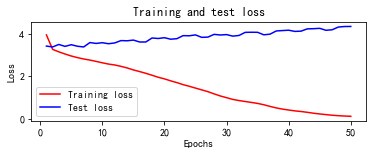

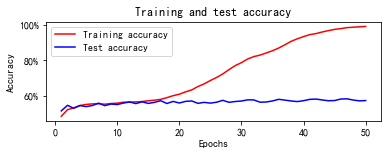

In [435]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [436]:
# Save weights
model.save_weights('NMT_Bi_GRU_Atten_Emb_50_epochs.h5')
# Load weights
model.load_weights('NMT_Bi_GRU_Atten_Emb_50_epochs.h5')

In [437]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
# Decoder setup
decoder_state_input = Input(shape=(latent_dim*2,))
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, decoder_states2 = decoder_gru(dec_emb2, initial_state=decoder_state_input)

# Attention layer
# (batch_size, max_length_inp, latent_dim) dot (latent_dim, latent_dim) => (batch_size, max_length_targ, latent_dim)
encoder2 = enc_dense(encoder_outputs)
# (batch_size, 1, latent_dim) dot (latent_dim, latent_dim) => (batch_size, 1, latent_dim)
decoder2 = dec_dense(decoder_outputs2)
# (batch_size, 1, latent_dim) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, max_length_inp)
score2 = dot([decoder2, encoder2], axes=[2, 2])#attention = dot([decoder, encoder], axes=[2, 2])
# (batch_size, 1, max_length_inp) dot (max_length_inp, max_length_inp) => (batch_size, 1, max_length_inp)
score2 = score_dense(score2)
attention_weights2 = Activation('softmax')(score2)

# Context vector
# (batch_size, 1, max_length_inp) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, latent_dim)
context2 = dot([attention_weights2, encoder2], axes = [2,1])
# (batch_size, 1, latent_dim)
decoder_combined_context2 = concatenate([context2, decoder_outputs2])
attention_vector2 = atten_dense(decoder_combined_context2)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(attention_vector2)
# Final decoder model
decoder_model = Model(
     [encoder_inputs] + [decoder_inputs] + [decoder_state_input],
     [decoder_outputs2] + [decoder_states2])

In [438]:
# Encoder model summary
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 49, 300)      949800      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 49, 600), (N 1081800     embedding_3[0][0]                
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 600)          0           bidirectional_2[0][1]            
                                                                 bidirectional_2[0][2]            
Total para

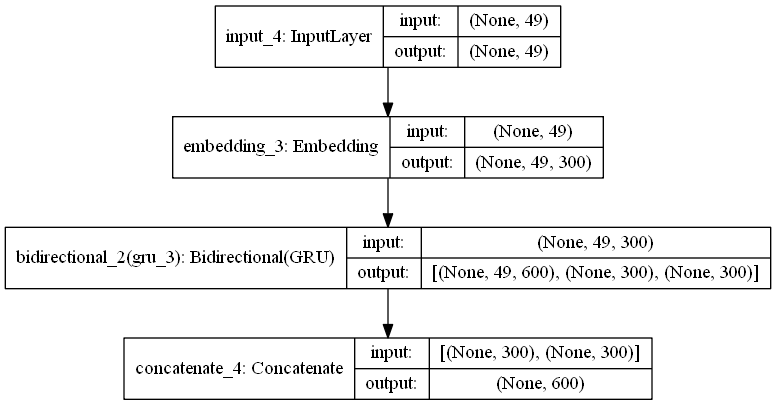

In [439]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [440]:
# Decoder model summary
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 300)    840000      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 600)          0                                            
__________________________________________________________________________________________________
embedding_

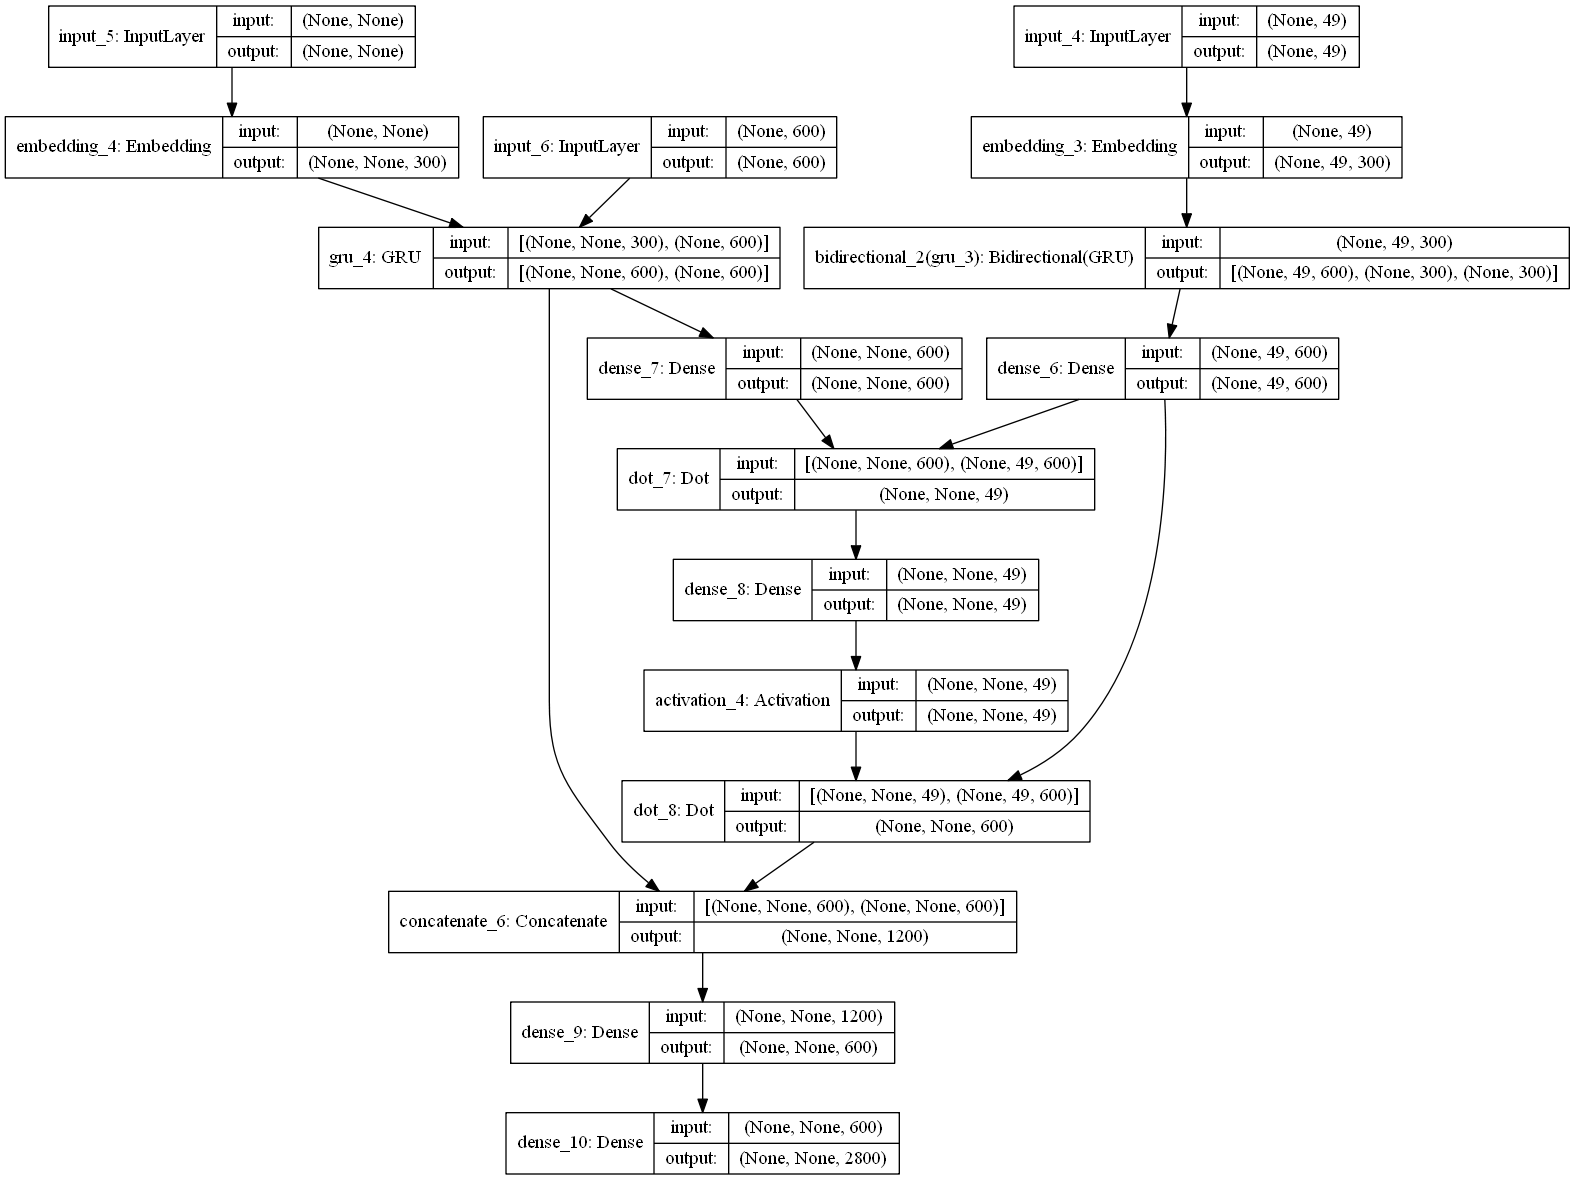

In [441]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [442]:
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    # Encode the input as state vectors.
    [encoder_outputs, states_value] = encoder_model.predict(input_seq)
    #print("input_seq",input_seq.shape, states_value.shape)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = targ_lang.word_index['<start>']
    # Final k predicted sentence
    decoded_sentence = ["" for x in range(k)]
    # Probabilities of each k candidates token in the sentence
    prop = [[0 for x in range(k)] for y in range(max_length_targ)]
    # Index of each k candidates token in the sentence 
    sampled_token_index = [[0 for x in range(k)] for y in range(max_length_targ)]
    # Sampled word of each k candidates token in the sentence 
    sampled_word = [["" for x in range(k)] for y in range(max_length_targ)]
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for l in range(max_length_targ):
        for i in range(k):
            output_tokens, states = decoder_model.predict([input_seq] + [target_seq] + [states_value])
            #print("output_tokens",output_tokens.shape, states.shape)
            # Sort Probabilities for candidates, get the indices 
            sampled_token_index[l][i] =  np.argsort(output_tokens[0, -1, :])[-(i+1)]
            # Sample words from index
            if sampled_token_index[l][i] != 0:
                sampled_word[l][i] = index_word_targ[sampled_token_index[l][i]]
            else:
                # error : No word was sampled
                #print(i,sampled_token_index[l][i],np.argsort(output_tokens[0, -1, :]))
                sampled_word[l][i] = ''
            # Mutiply Probabilities with previous setp
            prop[l][i] = (max(prop[l-1][:]) if l>0 else 0) + np.log(output_tokens[0, -1, sampled_token_index[l][i]])

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        # Sort candidates index by accumulated Probabilities
        prop_indices = np.argsort(prop[l][:])[::-1]

        # Stop sampling if we meet the '<end>' token which has the max Probability
        if sampled_word[l][prop_indices[0]] == '<end>':
            break

        # Forming k predicted sentence
        for idx in range(k):
            decoded_sentence[idx] += (' ' if l > 0 else '') + sampled_word[l][prop_indices[idx]]
            
         # Update states for next step       
        target_seq[0, 0] = sampled_token_index[l][prop_indices[0]]
        states_value = states
    return decoded_sentence

In [443]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

In [444]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

In [445]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence_with_k_beam_search(input_seq,5)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence[0])

Input Source sentence: 而 病人 也 将 带着 腹部 上 那 丑陋 的 永久性 伤疤 回家 。
Actual Target Translation: patients returned home with an ugly and permanent scar on their abdomen .
Predicted Target Translation: patients returned home with an ugly and permanent scar on their abdomen .


In [446]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

In [447]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence[0])

Input Source sentence: 把 宝宝 放在 你 的 腹部 ， 如果 脐带 足够 长 不 要 强行 拉扯 ， 就 放在 胸部 。
Actual Target Translation: place the baby on your abdomen or , if the cord is long enough don t tug at it , on your chest .
Predicted Target Translation: education in hygienic food handling for abattoir workers and raw meat producers is essential to keep contamination to a minimum .


In [448]:
from nltk.translate.bleu_score import sentence_bleu
reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
test = [token for token in decoded_sentence[0].split()]
score = sentence_bleu(reference, test)
print('Test - Predicted Target Translation:', test)
print('Reference - Actual Target Translation:', reference)
print('Bleu score:',score)

Test - Predicted Target Translation: ['education', 'in', 'hygienic', 'food', 'handling', 'for', 'abattoir', 'workers', 'and', 'raw', 'meat', 'producers', 'is', 'essential', 'to', 'keep', 'contamination', 'to', 'a', 'minimum', '.']
Reference - Actual Target Translation: [['place', 'the', 'baby', 'on', 'your', 'abdomen', 'or', ',', 'if', 'the', 'cord', 'is', 'long', 'enough', 'don', 't', 'tug', 'at', 'it', ',', 'on', 'your', 'chest', '.']]
Bleu score: 8.773420194004956e-232


H:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
H:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
H:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [449]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence[0].split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence[0])
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 360

Input Source sentence: 而 病人 也 将 带着 腹部 上 那 丑陋 的 永久性 伤疤 回家 。
Actual Target Translation: patients returned home with an ugly and permanent scar on their abdomen .
Predicted Target Translation: patients returned home with an ugly and permanent scar on their abdomen .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 360

Input Source sentence: 有些 人 之所以 会 这样 做 ， 是 因为 需要 获得 别人 的 喜爱 因为 我们 最 害怕 被 别人 抛弃 和 拒绝 。
Actual Target Translation: some of us do so because we need people to like us our greatest fear is of being abandoned and rejected .
Predicted Target Translation: some of us do so because we need people to like us our greatest fear is of being abandoned and rejected .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 360

Inp

Sample: 15 in total number of 360

Input Source sentence: 我们 将 在 本文 以及 整个 系列 中 使用 这个 缩写词 。
Actual Target Translation: we will use this abbreviation in this article and throughout the series .
Predicted Target Translation: i may use pen for writing and use abacus for statistics .
Bleu score: 1.1852285898528657e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 16 in total number of 360

Input Source sentence: 我 不 太 明白 ， 你 爸爸 要 我 ， 把 东西 都 带来 给做 你 家教 。 圣诞 之后 ， 我们 就 可以 重新 评估 一下 了 。
Actual Target Translation: i don t understand. your dad asked me to bring over all my stuff on homeschooling. aah ! after christmas , we can reevaluate .
Predicted Target Translation: i don t understand. your dad asked me to bring over all my stuff on homeschooling. aah ! after christmas , we can reevaluate .
Bleu score: 1.0
----------------------------------------------------------------------------------------------------------

Sample: 31 in total number of 360

Input Source sentence: 别名 是 缩写 的 命令名 和 命令行 短语 。
Actual Target Translation: an alias can abbreviate command names and command line phrases .
Predicted Target Translation: an alias can abbreviate command names and command line phrases .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 32 in total number of 360

Input Source sentence: 一 次 常规 的 腹部 例检 中 ， 医生 在 他 的 胰腺 中 发现 了 一 个 肿瘤 。
Actual Target Translation: during a routine abdominal scan , doctors had discovered a tumor growing in his pancreas .
Predicted Target Translation: the forest surrounding of the training was dedicated to fitness exercises , including loosening up ones , abdominals and dorsals .
Bleu score: 1.012071042130996e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 33 in total number of 360

Input Source sen

Sample: 47 in total number of 360

Input Source sentence: 当 我 同 那些 意识 不到 离婚 会 对 子女 带来 巨大 打击 的 父母 交谈 时 ， 我 往往 为 之 震惊 。
Actual Target Translation: i m always taken aback when i communicate with parents who have no understanding of the devastation divorce cause s children .
Predicted Target Translation: education in hygienic food handling for abattoir workers and raw meat producers is essential to keep contamination to a minimum .
Bleu score: 8.114706383546217e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 48 in total number of 360

Input Source sentence: 用显微镜 观察 鲍鱼 壳 的 内 表面 ， 你 可以 发现 一些 刮痕 ， 这些 都 有 可能 是 在 混合 颜料 的 过程 中 留下 来的 。
Actual Target Translation: microscopic striations on the inner abalone surface likely are likely scrape marks left during paint mixing .
Predicted Target Translation: microscopic striations on the inner abalone surface likely are likely scrape marks left during paint mixing .
Ble

Sample: 63 in total number of 360

Input Source sentence: 在 僧人 的 引导 下 ， 他 先到 寺 中 千 佛殿 参观 500 罗汉 壁画 ， 接着 观看 30 分钟 的 武术 表演 ， 此后 还 向 少林寺 方丈 释永信 讨教 了 不少 练功 的 方法 。
Actual Target Translation: after watching a 30 minute kungfu performance by shaolin monks , holyfield asked shaolin abbot shi yongxin for some advice on kungfu . see photo
Predicted Target Translation: the million dollar puppy that s been fattened with abalone , or the grimy dog with brown and white splotches who stood over his friend until he found help which do you think of as a perfect specimen ?
Bleu score: 8.669612184277444e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 64 in total number of 360

Input Source sentence: 于是 他 爬上 当地 大教堂 顶 往下 跳 ， 以此 证明 他 信仰 的 力量 结果 呢 ， 那个 酒馆 就 成 了 他 的 坟墓 ！
Actual Target Translation: he jumped from the top of the local abbey to demonstrate his faith and well , the pub was a nice memorial !
Predicted Target Tra

Sample: 79 in total number of 360

Input Source sentence: 我 和 小组 中 其他 几 位 职场 上 的 年轻 人 都 被 他 不经意 的 回答 吓 了 一 跳 。
Actual Target Translation: i , and several of the other young professionals in our group , were taken aback by his casual remark .
Predicted Target Translation: i , and several of the other young professionals in our group , were taken aback by his casual remark .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 80 in total number of 360

Input Source sentence: 你们 中 很多 人 以为 这 种 把 责任 交还 给 人们 自己 的 方式 意味 着 放弃 他们 或者 让 他们 完全 靠 自己 解决 题目 。
Actual Target Translation: many of you feel that returning responsibility to people in this way means to abandon them or to tell them to solve the issue all by themselves .
Predicted Target Translation: many of you feel that returning responsibility to people in this way means to abandon them or to tell them to solve the issue all by themselves .
Bleu s

Sample: 94 in total number of 360

Input Source sentence: 首先 准备 拜访 的 是 江 浙 沪 三 地 年龄 最 长 的 杭州 灵隐寺 方丈 木鱼 大师 。
Actual Target Translation: in the area of jiang , zhe , hu , the oldest abbot of hangzhou lingyin temple master muyu was on the priority of the visit agenda .
Predicted Target Translation: in the area of jiang , zhe , hu , the oldest abbot of hangzhou lingyin temple master muyu was on the priority of the visit agenda .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 95 in total number of 360

Input Source sentence: 最 重要 的 是 ， 自然 摄影 以 我们 在 抛弃 自然 的 现代 生活 中 早 已 失去 的 东西 那 种 奇观 的 体验 ， 那 种 发现 新奇 和 敬畏 的 感觉 丰富 我们 的 生活 。
Actual Target Translation: above all , nature photography lends to our lives what we long ago lost in our modern abandonment of nature the experience of wonderment , that sense of discovery , newness and awe .
Predicted Target Translation: above all , nature photography lends

Sample: 110 in total number of 360

Input Source sentence: 拒绝 掌管权 。 当你 面临 要 作出 一 个 巨大 的 决策 时 ， 你 可能 更 倾向于 把 这 项 职责 转交 给 其他 人 。
Actual Target Translation: refusal to take charge when it comes to the bigger decisions that you need to make , you may well prefer to abdicate the responsibility to someone else .
Predicted Target Translation: refusal to take charge when it comes to the bigger decisions that you need to make , you may well prefer to abdicate the responsibility to someone else .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 111 in total number of 360

Input Source sentence: 中华 人民 共和国 于 一九四九年 十月 一日 成立 。
Actual Target Translation: the people s republic of china was founded on october 1 , 1949 .
Predicted Target Translation: the people s republic of china was founded on october 1 , 1949 .
Bleu score: 1.0
-------------------------------------------------------------------------------

Sample: 126 in total number of 360

Input Source sentence: 代码 生成 程序 可以 对 这 种 语句 进行 简化 ， 并 节省 很多 输入 的 工作 ， 这 可以 防止 大量 的 输入 错误 ， 因为 减少 了 很多 输入 错误 内容 的 机会 。
Actual Target Translation: code generating programs allow you to abbreviate such statements and save a lot of typing , which also prevents a lot of mistakes because there is less chance of mistyping .
Predicted Target Translation: the million dollar puppy that s been fattened with abalone , or the grimy dog with brown and white splotches who stood over his friend until he found help which do you think of as a perfect specimen ?
Bleu score: 1.1409851298103347e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 127 in total number of 360

Input Source sentence: 在 你 没有 时间 的 时候 你 需要 知道 你 应该 放弃 什么 。
Actual Target Translation: you need to know what to abandon if you run out of time .
Predicted Target Translation: you need to know what to abandon if you run ou

Sample: 141 in total number of 360

Input Source sentence: 只有 它们 不 会 遗弃 我 ， 只有 它们 不 会 背叛 。
Actual Target Translation: only they will not abandon me , only they will not betray .
Predicted Target Translation: we will use this abbreviation in this article and throughout the series .
Bleu score: 1.1409851298103347e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 142 in total number of 360

Input Source sentence: 在 论文 中 作者们 选择 了 这个 氨基酸 序列 的 缩写 形式 。
Actual Target Translation: and there the authors chose to abbreviate the amino acid sequence .
Predicted Target Translation: and there the authors chose to abbreviate the amino acid sequence .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 143 in total number of 360

Input Source sentence: 我们 把 信 和 艾比 和 梅瑞迪斯 在 一起 的 照片 一起 放进 了 信封 ， 一 封 写给 上帝 的 信 。
Actual Target Tra

Sample: 157 in total number of 360

Input Source sentence: 新的 手术 切口 会 部分 或 全部 经过 以前 的 手术 切口 皮肤 皮下 脂肪 进入 腹部 。
Actual Target Translation: it may go through part or all of a previous incision , skin , an underlying fatty layer and into the abdomen .
Predicted Target Translation: the inspection is the nuns hope to these the abdominals , histogram aah , abdominals , diarrhoea , or their specific role .
Bleu score: 1.2439956612288083e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 158 in total number of 360

Input Source sentence: 一 新 研究 报告 ， 罹患 癌症 的 儿童 发生 糖尿病 的 危险 比 他们 的 兄弟 姐妹 大得 多 ， 特别是 如果 他们 涉及 腹部 或是 全身 照射 治疗 。
Actual Target Translation: childhood cancer survivors are at much greater risk of developing diabetes than their siblings , especially if their treatment involved radiation of the abdomen or total body , a new study reports .
Predicted Target Translation: the surgeon eventually led the police to 

Sample: 171 in total number of 360

Input Source sentence: 多数 病例 的 临床 特征 包括 发热 头痛 腹泻 或 绞痛性 腹部 疼痛 以及 呕吐 。
Actual Target Translation: the clinical features in the majority of cases include fever , headache , diarrhoea or colicky abdominal pain , and vomiting .
Predicted Target Translation: the clinical features in the majority of cases include fever , headache , diarrhoea or colicky abdominal pain , and vomiting .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 172 in total number of 360

Input Source sentence: 价值 百万 美元 每 日 以 鲍鱼 喂食 的 小狗 ， 还是 坚守 在 伙伴 身边 直 到 获救 的 脏兮兮 的 棕白 斑点 狗 ， 哪 一 个 才 是 狗 中 的 完美 典范 ， 你 认为 呢 ？
Actual Target Translation: the million dollar puppy that s been fattened with abalone , or the grimy dog with brown and white splotches who stood over his friend until he found help which do you think of as a perfect specimen ?
Predicted Target Translation: the million dollar puppy that

Sample: 184 in total number of 360

Input Source sentence: 毫 无 疑问 ， 你 肯定 想 知道 我 离开 学校 以来 的 情况 。
Actual Target Translation: no doubt you would like to know how i have been getting along since i left school .
Predicted Target Translation: no doubt you would like to know how i have been getting along since i left school .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 185 in total number of 360

Input Source sentence: 然而 ， 在 第五 年 ， 从一开始 就 报告 有 高度 抑郁 的 人 ， 腹部 肥胖 和 bmi 增长 的 速度 要 快于 那些 报告 了 更少 抑郁 症状 的 人 。
Actual Target Translation: however , the people who started out reporting high levels of depression increased in abdominal obesity and bmi at a faster rate than those who reported fewer symptoms of depression at year five .
Predicted Target Translation: the year old egypt pollution abatement project ii leveraged a us 20 million world bank loan to attract another us 145 million in financing .
B

Sample: 198 in total number of 360

Input Source sentence: 她 把 一 束 花 放在 桌边 。
Actual Target Translation: she put a bunch of flowers by the edge of the table .
Predicted Target Translation: the alarm was raised as soon as the fire was discovered .
Bleu score: 1.1852285898528657e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 199 in total number of 360

Input Source sentence: 这个 寺院 ， 有 1500年 之久 ， 有 一 个 被 成为 少林寺 ceo 的 方丈 他 以 顾问 投资者 和 演出 人员 提供者 的 身份 服务 于 这 次 演出 。
Actual Target Translation: the temple , 1 , 500 years old , has an abbot who is referred to here as its chief executive he served as an adviser and investor and even offered temple monks as performers .
Predicted Target Translation: the temple , 1 , 500 years old , has an abbot who is referred to here as its chief executive he served as an adviser and investor and even offered temple monks as performers .
Bleu score: 1.0
-------------------------

Sample: 213 in total number of 360

Input Source sentence: 其他 字符串 可能 是 特定 数目 的 字符 ， 例如 两 个 字母 表示 的 美国 各 州 的 缩写 。
Actual Target Translation: other strings may have to be a certain number of characters , too , such as two letters for a u .s. state abbreviation .
Predicted Target Translation: other strings may have to be a certain number of characters , too , such as two letters for a u .s. state abbreviation .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 214 in total number of 360

Input Source sentence: 另外 ， 提出 一 种 改进 的 直方图 平均 面积 直方图 ， 以 提取 色彩 特征 。
Actual Target Translation: moreover , an improvement on the traditional histogram called the average area histogram aah is proposed to represent color features .
Predicted Target Translation: the inspection is usually carried out by designated veterinarians or meat inspectors at the abattoir .
Bleu score: 9.424890216415306e-232
---------------

Sample: 228 in total number of 360

Input Source sentence: 注意 我们 如何 在 cos x 曲线 中 将 with 缩 写成 w 。
Actual Target Translation: notice how we abbreviate with as w in the cos x curve .
Predicted Target Translation: the problem has persisted for about three or four weeks now , with no sign of abatement .
Bleu score: 1.1640469867513693e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 229 in total number of 360

Input Source sentence: 已经 历时 一 年 的 第二 个 埃及 减轻 污染 项目 调动 了 2000万 美元 的 世界 银行 贷款 ， 以 吸引 另外 1 45亿 美元 的 融资 。
Actual Target Translation: the year old egypt pollution abatement project ii leveraged a us 20 million world bank loan to attract another us 145 million in financing .
Predicted Target Translation: the year old egypt pollution abatement project ii leveraged a us 20 million world bank loan to attract another us 145 million in financing .
Bleu score: 1.0
------------------------------------------------

Sample: 242 in total number of 360

Input Source sentence: 从 现在 到 2020年 期间 ， 森林 和 其他 植物 吸收 大气 中 的 碳 ， 有可能 提供 超过 40 的 碳 减排 机会 。
Actual Target Translation: forests and plants remove carbon from the atmosphere , potentially accounting for more than 40 of carbon abatement opportunities between now and 2020 .
Predicted Target Translation: forests and plants remove carbon from the atmosphere , potentially accounting for more than 40 of carbon abatement opportunities between now and 2020 .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 243 in total number of 360

Input Source sentence: 那个 男人 无耻地 遗弃 了 妻儿 ， 另 寻 新欢 。
Actual Target Translation: the man shamelessly abandoned his wife and child for another woman .
Predicted Target Translation: the alarm was raised as soon as the fire was discovered .
Bleu score: 1.1640469867513693e-231
------------------------------------------------------------------

Sample: 257 in total number of 360

Input Source sentence: 向 屠宰厂 工人 以及 生肉 生产商 开展 卫生 食品 操作 方面 的 教育 ， 对于 尽可能 降低 污染 程度 至关 重要 。
Actual Target Translation: education in hygienic food handling for abattoir workers and raw meat producers is essential to keep contamination to a minimum .
Predicted Target Translation: the abbot , or hegoumenos , the leader of the greek orthodox monastery , assigns each monk a specific role .
Bleu score: 1.012071042130996e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 258 in total number of 360

Input Source sentence: 酵母 通常 不 会 对 二氧化碳 等 做出 自我 反应 ， 所以 贝尔彻 和 她 的 学生们 必须 改造 它们 来 表达 类似 鲍鱼 机体 中的 那些 基因 。
Actual Target Translation: yeast don t normally do any of those reactions on their own , so belcher and her students had to engineer them to express genes found in organisms such as the abalone .
Predicted Target Translation: the investigation eventually led the police to conduct an

Sample: 271 in total number of 360

Input Source sentence: 关于 男人 的 美 有 一 条 确定 的 标准 ， 就是 放下 巴 和 微微 隆起 的 肚子 。
Actual Target Translation: granted , there s a definite beauty standard for males the square jawed male models with rippling abdominals tom cruise and of course john f .
Predicted Target Translation: granted , there s a definite beauty standard for males the square jawed male models with rippling abdominals tom cruise and of course john f .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 272 in total number of 360

Input Source sentence: 等待 前往 威斯敏斯特 大 教堂 的 几 个 小时 是 最 令 人 不安 的 。
Actual Target Translation: the hours of waiting before leaving for westminster abbey were the most nerve racking .
Predicted Target Translation: the hours of waiting before leaving for westminster abbey were the most nerve racking .
Bleu score: 1.0
--------------------------------------------------------------

Sample: 287 in total number of 360

Input Source sentence: 在 本例 中 ， 最大 长度 是 2 ， 这 表示 美国 各 个 州 的 邮政 缩写 。
Actual Target Translation: in this case , that maximum length is 2 , which is the understood postal abbreviation for a state in the united states .
Predicted Target Translation: in this case , that maximum length is 2 , which is the understood postal abbreviation for a state in the united states .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 288 in total number of 360

Input Source sentence: 但是 科学家 和 发展 工作者 说 ， 当时 这 场 运动 实际上 推广 的 是 abc 所有 成分 ， 特别是 关于 艾滋病 病毒 和 安全套 使用 的 教育 。
Actual Target Translation: but researchers and development workers say that back then , the campaign actually promoted all components of abc , especially education about the virus and condom use .
Predicted Target Translation: after the morning ceremony , the abbey of the local when and victim to the abbot of the ab

Sample: 301 in total number of 360

Input Source sentence: 高盛 承认 abacus 2007 ac1 交易 的 销售 材料 含有 不完整 信息 。
Actual Target Translation: goldman acknowledges that the marketing materials for the abacus 2007 ac1 transaction contained incomplete information .
Predicted Target Translation: goldman acknowledges that the marketing materials for the abacus 2007 ac1 transaction contained incomplete information .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 302 in total number of 360

Input Source sentence: 2008年 ， 研究 人员 在 南非 的 山洞 中 发现 了 赭石 混合 工具 ， 两 个 可能 用于 调漆 和 储存 的 鲍鱼 壳 ， 除此之外 他们 还 发现 了 赭石 ， 骨头 ， 炭笔 和 石锤 。
Actual Target Translation: then , in 2008 , researchers uncovered an ochre mixing kit in a south african cave. they found two abalone shells , most likely used for paint mixing and storage .
Predicted Target Translation: then , it was that only because in the pelvic of because rogues would not a

Sample: 316 in total number of 360

Input Source sentence: 修道院 院长 ， 这个 希腊 东正教 修道院 的 头 ， 给 每 个 修 道士 分配 工作 。
Actual Target Translation: the abbot , or hegoumenos , the leader of the greek orthodox monastery , assigns each monk a specific role .
Predicted Target Translation: the abbot , or hegoumenos , the leader of the greek orthodox monastery , assigns each monk a specific role .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 317 in total number of 360

Input Source sentence: 当 球 上 的 数千 盏 小 灯 亮起 时 ， 人群 一 阵 欢呼雀跃 。
Actual Target Translation: they ooh and aah when the thousands of little lights in the ball come on .
Predicted Target Translation: they ooh and aah when the thousands of little lights in the ball come on .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 318 in total number of 360

In

Sample: 332 in total number of 360

Input Source sentence: 蒙马特尔 的 阴沟 和 大 阴渠 接头 的 地方 ， 另 有 两 条 地下 坑道 ， 一 条 是 普罗旺斯 街 的 ， 另 一 条 是 屠宰场 的 ， 形成 了 一 个 十字 路口 。
Actual Target Translation: at the point where the montmartre sewer joins the grand sewer , two other subterranean galleries , that of the rue de provence , and that of the abattoir , form a square .
Predicted Target Translation: at the point where the montmartre sewer joins the grand sewer , two other subterranean galleries , that of the rue de provence , and that of the abattoir , form a square .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 333 in total number of 360

Input Source sentence: 被 石道 姑 这 一 撞破 ， 那 女子 多半 受 了 惊吓 ， 第二 天 未 曾 再来 。
Actual Target Translation: most likely the girl was scared by abbess shih , for she did not come the following evening .
Predicted Target Translation: the problem utility of simple to use provide a repea

Sample: 346 in total number of 360

Input Source sentence: 为了 做好 准备 ， 应该 从 腹部 的 上面 到 下面 同时 进行 收缩 。
Actual Target Translation: prepare for the exercise by bracing your abdominals from top to bottom .
Predicted Target Translation: the inspection is the nuns hope to fitness the abdominals , histogram when , again , ones to bottom .
Bleu score: 2.388207634960466e-78
-------------------------------------------------------------------------------------------------------------------------
Sample: 347 in total number of 360

Input Source sentence: 中国 媒体 把 释 称作 中国 最 有 争议 的 僧人 和 mba 方丈 。
Actual Target Translation: chinese media have dubbed shi the country s most controversial monk and the abbot with the mba .
Predicted Target Translation: chinese media have dubbed shi the country s most controversial monk and the abbot with the mba .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 348 in total numbe

In [450]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence[0].split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence[0])
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 90

Input Source sentence: 把 宝宝 放在 你 的 腹部 ， 如果 脐带 足够 长 不 要 强行 拉扯 ， 就 放在 胸部 。
Actual Target Translation: place the baby on your abdomen or , if the cord is long enough don t tug at it , on your chest .
Predicted Target Translation: education in hygienic food handling for abattoir workers and raw meat producers is essential to keep contamination to a minimum .
Bleu score: 8.773420194004956e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 90

Input Source sentence: 而且 上腹部 器官 如肝 ， 肾 ， 胆囊 也 没有 问题 。
Actual Target Translation: no problems with upper abdominal organs either liver , kidneys , gall bladder .
Predicted Target Translation: the two clusters of tools and two ocher filled abalone shells were found in 2008 .
Bleu score: 9.109159947227211e-232
--------------------------------------------------------------------------------------------------------------

Sample: 15 in total number of 90

Input Source sentence: 如果 你 今天 去 参观 威斯敏斯特 大 教堂 ， 你 觉 埋葬 在 那里 的 ， 有 多少 是 伦敦人 ？
Actual Target Translation: if you went to westminster abbey today and looked at the people buried there , how many are londoners ?
Predicted Target Translation: you can not that to foot about their students , you you need and one abbey .
Bleu score: 1.1246008090484111e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 16 in total number of 90

Input Source sentence: 电视 主播 说 ， 阿里山 上 的 村民 攀爬 下山 来到 一 个 废弃 的 警察局 通过 无线电 请求 援助 。
Actual Target Translation: broadcasters said villagers on alishan had crawled down the mountainside to an abandoned police station to request aid by radio .
Predicted Target Translation: the forest , the abbot of the powerful of villiers sheltered these unfortunate people who had been scattered abroad , for many days and nights .
Bleu score: 1.0618063059647207e-231
---------

Sample: 30 in total number of 90

Input Source sentence: 但是 即使 是 研究 中国 问题 的 专家 也 会 对 中国 金融 资本 的 发展 感到 惊讶 。
Actual Target Translation: but even china watchers may have been taken aback by a development in china s financial capital .
Predicted Target Translation: other strings may have to be a certain number of characters , too , such as two letters for a u .s. state abbreviation .
Bleu score: 4.262352868760118e-155
-------------------------------------------------------------------------------------------------------------------------
Sample: 31 in total number of 90

Input Source sentence: 慢慢 往后 靠 ， 弯腰 并且 时刻 保持 腹部 肌肉 收紧 。
Actual Target Translation: slowly lie back , tucking in and tightening your abdominals at all times .
Predicted Target Translation: the people s republic of china was founded on october 1 , 1949 .
Bleu score: 1.1200407237786664e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 32 in t

Sample: 44 in total number of 90

Input Source sentence: 我 把 一 袋 废弃 的 潮湿 发霉 的 游泳 用具 踢到 一边 。
Actual Target Translation: i kick aside an abandoned bag of swimming gear , damp and mildewed .
Predicted Target Translation: goldman acknowledges that the marketing materials for the abacus 2007 ac1 transaction contained incomplete information .
Bleu score: 9.109159947227211e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 45 in total number of 90

Input Source sentence: 我 到 得很 早 ， 以免 错过 什么 。
Actual Target Translation: i arrived early in order that i might not miss anything .
Predicted Target Translation: the two clusters of tools and two ocher filled abalone shells were found in 2008 .
Bleu score: 1.0832677820940877e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 46 in total number of 90

Input Source sentence: 几 个 月 后 ， 她 

Sample: 59 in total number of 90

Input Source sentence: 实现 这 一 目标 的 职责 主要 在于 有关 公共 卫生 当局 。 通常 ， 兽医 和 屠宰场 肉类 检验 人员 代表 着 公共 卫生 当局 。
Actual Target Translation: the responsibility for achieving this objective lies primarily with the relevant public health authorities who are normally represented by veterinarians or meat inspectors at the abattoir .
Predicted Target Translation: the emphasis of the exercises is to strengthen the abdominals , improve posture , stabilize and lengthen the spine , improve balance and overall strength .
Bleu score: 1.0979342939701849e-231
-------------------------------------------------------------------------------------------------------------------------
Sample: 60 in total number of 90

Input Source sentence: 举 腿 pulses 下腹 平躺 把 你 的 双 手 置于 臀部 并 举起 你 的 脚 指向 屋顶 。
Actual Target Translation: c . pulses lower abdominals lie flat on your back and place your hands under your bottom and raise your feet towards the ceiling .
Predicted Target Translation: russian sol

Sample: 72 in total number of 90

Input Source sentence: 旅馆 招待员 想知道 我们 明天 早上 什么 时候 离开 。
Actual Target Translation: the hotel receptionist wants to know when we will be checking out tomorrow morning .
Predicted Target Translation: the alarm was raised as soon as the fire was discovered .
Bleu score: 9.065607048138757e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 73 in total number of 90

Input Source sentence: 好 消息 是 已经 出人意料 地 有 大量 融资 作为 治理 气候 变暖 的 投资 ， 成为 恢复 措施 。
Actual Target Translation: the good news is that there is already a surprisingly large flow of climate finance as investment into warming abatement and resilience measures is called .
Predicted Target Translation: it s the only was the powerful monastery and gives financial support to institutions throughout the area .
Bleu score: 7.463640991159612e-232
---------------------------------------------------------------------------------------

Sample: 87 in total number of 90

Input Source sentence: 她 指给 我们 曾祖父母 埋藏 的 地方 ， 那 是 个 12 世纪 的 西 多 会 修道院 。
Actual Target Translation: she directed us to where my great grandparents were buried amid the ruins of a 12th century cistercian abbey .
Predicted Target Translation: the 10 prefessor came that to chine in 1949 when the mainland had just been liberated .
Bleu score: 9.897743712508829e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 88 in total number of 90

Input Source sentence: 尽可能 坐直 ， 肩膀 向后 ， 一 只 手 放在 上 胸部 ， 另 一 只 手 放在 腰 以上 的 腹部 。 正确 的 姿势 能 使 胸腔 低处 更 好 地 扩展 。
Actual Target Translation: sit up as straight as possible , shoulders back , one hand on your upper chest , the other on your abdomen just above waist .
Predicted Target Translation: the abbess left them , and little john bound up the vein quickly . but he saw that robin s lips were almost white , and heard how his breath came with flutt

In [451]:
model.save('NMT_Bi_GRU_Atten_Emb_50_epochs_model.h5')

C:\Users\lilan\AppData\Roaming\Python\Python36\site-packages\keras\engine\network.py:877: UserWarning: Layer gru_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_4/concat:0' shape=(?, 600) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [452]:
from keras.models import load_model
model = load_model('NMT_Bi_GRU_Atten_Emb_50_epochs_model.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 49, 300)      949800      input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 49, 600), (N 1081800     embedding_3[0][0]                
__________________________________________________________________________________________________
embedding_

In [453]:
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']

def plot_attention(attention_map, input_tags = None, output_tags = None):    
    attn_len = len(attention_map)

    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(15, 15))
    ax = f.add_subplot(1, 1, 1)

    # Add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # Add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # Add labels
    ax.set_yticks(range(attention_map.shape[0]))
    if output_tags != None:
        ax.set_yticklabels(output_tags[:attn_len])

    ax.set_xticks(range(attention_map.shape[1]))
    if input_tags != None:
        ax.set_xticklabels(input_tags[:attn_len], rotation=60)
    ax.tick_params(axis="x", labeltop=True)
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    plt.show()

# input_tags - word representation of input sequence, use None to skip
# output_tags - word representation of output sequence, use None to skip
# i - index of input element in batch

In [455]:
visual_model = Model(inputs = model.input, output = [model.output, model.get_layer('activation_3').output])
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

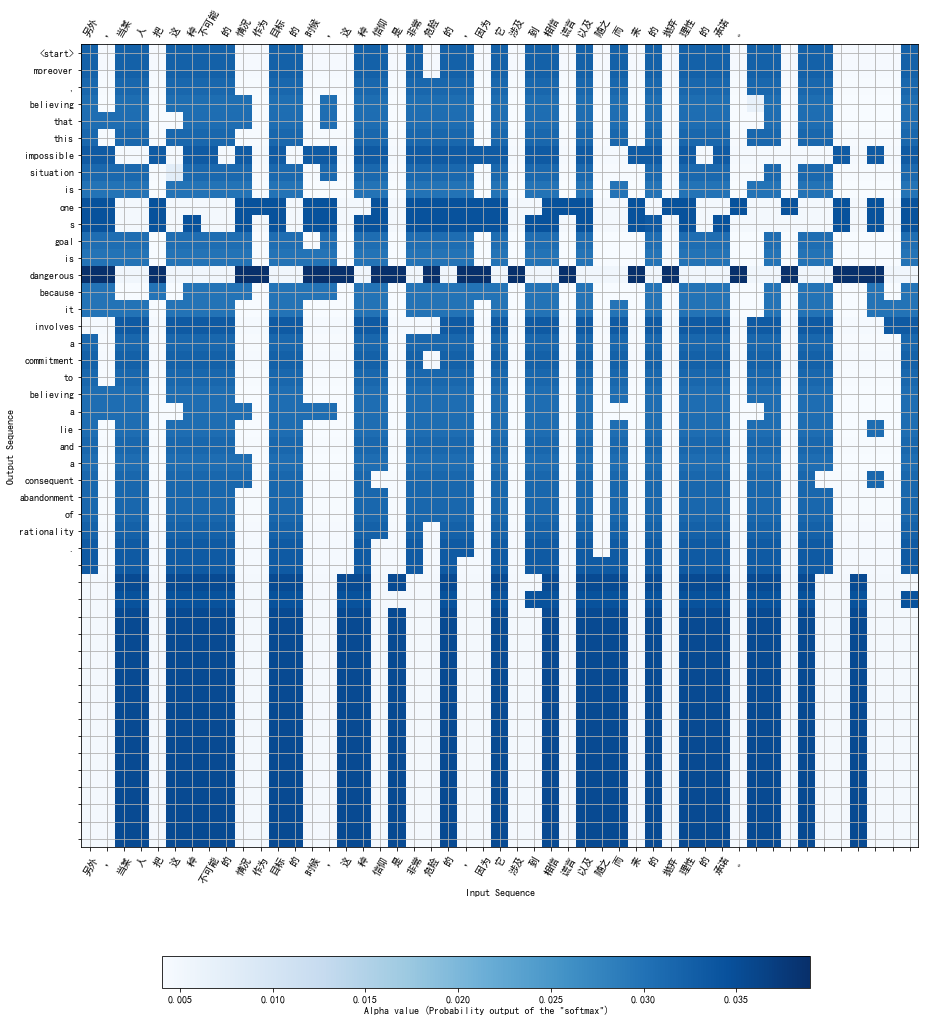

In [460]:
#(input_seq, actual_output), _ = next(train_gen)
outputs = visual_model.predict([input_seq,actual_output])
model_outputs = outputs[0]
attention_outputs = outputs[1]
an_attention_output = attention_outputs[0]
x = len([token for token in sequence_to_text(index_word_inp, input_seq[0].tolist()).split()])
y = len([token for token in sequence_to_text(index_word_targ, actual_output[0].tolist()).split()])
plot_attention(an_attention_output,[index_word_inp[i] for i in input_seq[0] if i != 0],[index_word_targ[i] for i in actual_output[0] if i != 0])